## Classification of Non and Biodegradable Material using ResNet50

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os 

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-06-28 18:29:06.245216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Import the datasets into train,test and validation sets using tensorflow datasets.

In [2]:
path = "/home/developer/Coding/Kaggle/BioNonBioDegradable/BioNonBioDATA/"
train_dir = [os.path.join(path, 'TRAIN.{}'.format(d)) for d in range(1,5)] #1 Dimensional Array. Represent Training Subset Directories.
test_dir = os.path.join(path, 'TEST') #Evaluation Subset Directory.
classes = ['B','N'] #Binary Class Used for Dataset Generator. 

im_size = (64, 64) #Output Image Size for Dataset Generator.
batch_size = 32 #Batch Size Used in Dataset Generator.
seed = np.random.randint(123456789) #Seed for Shuffling in Dataset Generator.
val_split = 0.1 #Fraction for Validation Subset (0.1 = 10% of Training Subset).

In [3]:
train_dataset = None

for directory in train_dir:
    #For every Training Subset Part.
    #Convert Image from Directory to tf.data.Dataset() Object.
    subdataset = image_dataset_from_directory(
        directory=directory, #Source Directory.
        label_mode = 'binary', #Labeling Mode. 
        class_names = classes,
        color_mode = 'rgb', #Color Channel.
        batch_size = batch_size,
        image_size = im_size,
        seed=seed,
        shuffle=True,
        validation_split=val_split,
        subset = 'training' #Subset Indicator. Use Data Readed as Training Subset.
    )
    #Concatenate Each Part of Training Subset to Single Dataset.
    try:
        train_dataset = train_dataset.concatenate(subdataset)
    except:
        train_dataset = subdataset

Found 59922 files belonging to 2 classes.
Using 53930 files for training.


2025-06-28 18:29:09.871128: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 59922 files belonging to 2 classes.
Using 53930 files for training.
Found 59922 files belonging to 2 classes.
Using 53930 files for training.
Found 59924 files belonging to 2 classes.
Using 53932 files for training.


In [4]:
validation_dataset = None
for directory in train_dir:
    #For every Training Subset Part.
    #Convert Image from Directory to tf.data.Dataset() Object.
    subdataset = image_dataset_from_directory(
        directory=directory, #Source Directory.
        label_mode='binary', #Labeling Mode. 
        class_names=classes,
        color_mode='rgb', #Color Channel.
        batch_size=batch_size,
        image_size=im_size,
        seed=seed,
        shuffle=True,
        validation_split=val_split,
        subset='validation' #Subset Indicator. Use Data Readed as Validation Subset.
    )
    #Concatenate Each Part of Validation Subset to Single Dataset.
    try:
        validation_dataset = train_dataset.concatenate(subdataset)
    except:
        validation_dataset = subdataset

Found 59922 files belonging to 2 classes.
Using 5992 files for validation.
Found 59922 files belonging to 2 classes.
Using 5992 files for validation.
Found 59922 files belonging to 2 classes.
Using 5992 files for validation.
Found 59924 files belonging to 2 classes.
Using 5992 files for validation.


In [5]:
#Convert Image from Directory to tf.data.Dataset() Object.
test_dataset = image_dataset_from_directory(
    directory=test_dir, #Source Directory.
    label_mode='binary', #Labeling Mode. 
    class_names=classes,
    color_mode='rgb', #Color Channel.
    batch_size=batch_size,
    image_size=im_size
)

Found 16726 files belonging to 2 classes.


In [6]:
#Data Pipeline Optimization

#Prefetch, Overlaps the Preprocessing and Model Execution of a Training Step. Reading +1 batch of current batch execution. 
#Reduce Latency because Pipeline Reading Data when It Execute.

#Cache, Create Cache File of Dataset in Memory or Disk.
#Use .cache() to Create Cache on Memory. Faster, but Resource Consuming.
#Use .cache(dir_to_file) to Create Cache on Specific Directory on Disk.
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


#### Create model for binary classification using ResNet50 as base model and putting layers on top of it and finetuning the model 

In [7]:
def create_model():
  pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

  # Since data is of more than 2GB(250k records in train) decided to fine tune the model and add extra classification layer on top it.
  for layer in pretrained_model.layers[:140]:  # Keep first 140 layers frozen
        layer.trainable = False
  for layer in pretrained_model.layers[140:]:  # Unfreeze last few layers
        layer.trainable = True

  # Add fully connected layers for classification
  x = pretrained_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.4)(x)
  predictions = Dense(1, activation='sigmoid')(x) # Changed to 1 neuron for binary classification


  model = Model(inputs=pretrained_model.input, outputs=predictions)
  return model

In [8]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=1e-4),  # Reduced LR because we are finetuning
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [10]:
history = model.fit(train_dataset, epochs=4, validation_data=validation_dataset)

Epoch 1/4


2025-06-28 18:29:27.118583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [53930]
	 [[{{node Placeholder/_4}}]]
2025-06-28 18:29:27.119347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [53930]
	 [[{{node Placeholder/_4}}]]


6744/6744 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9480

2025-06-28 22:33:29.002660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype string and shape [53930]
	 [[{{node Placeholder/_39}}]]
2025-06-28 22:33:29.003763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype string and shape [53930]
	 [[{{node Placeholder/_39}}]]


6744/6744 [==============================] - 23571s 3s/step - loss: 0.1394 - accuracy: 0.9480 - val_loss: 0.0834 - val_accuracy: 0.9709
Epoch 2/4
6744/6744 [==============================] - 22249s 3s/step - loss: 0.0822 - accuracy: 0.9705 - val_loss: 0.0583 - val_accuracy: 0.9812
Epoch 3/4
6744/6744 [==============================] - 22068s 3s/step - loss: 0.0444 - accuracy: 0.9843 - val_loss: 0.0424 - val_accuracy: 0.9854
Epoch 4/4
6744/6744 [==============================] - 22039s 3s/step - loss: 0.0265 - accuracy: 0.9908 - val_loss: 0.0299 - val_accuracy: 0.9895


In [11]:
model.save("BioOrNonBioModel.h5")

In [12]:
test_result = model.evaluate(test_dataset,use_multiprocessing=True,return_dict=True)

2025-06-29 19:54:14.776365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16726]
	 [[{{node Placeholder/_4}}]]
2025-06-29 19:54:14.811441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16726]
	 [[{{node Placeholder/_0}}]]


523/523 [==============================] - 699s 1s/step - loss: 0.3899 - accuracy: 0.9054


/tmp/ipykernel_127396/3336742283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_127396/3336742283.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


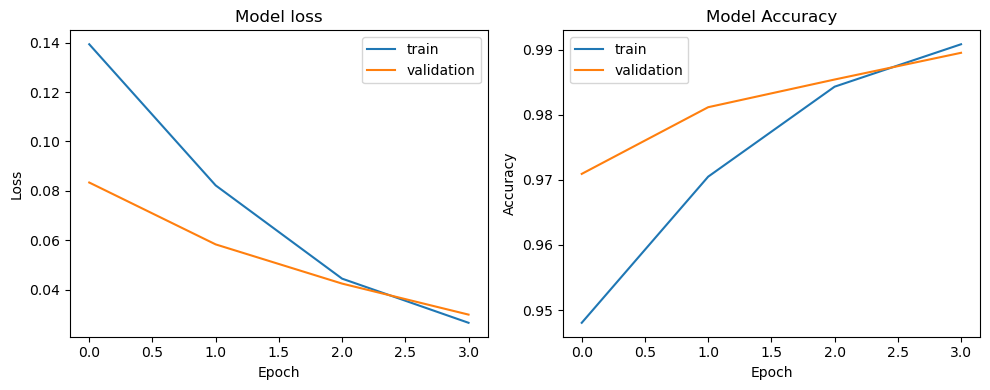

In [19]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
df_loss.plot(ax=axes[0],title='Model loss').set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(ax=axes[1],title='Model Accuracy').set(xlabel='Epoch',ylabel='Accuracy')
plt.tight_layout()
plt.show()

In [23]:
print("Test dataset loss = ",test_result['loss'])
print("Test dataset loss = ",test_result['accuracy'])

Test dataset loss =  0.38986045122146606
Test dataset loss =  0.90541672706604


Conclution: Validation Accuracy:98% and Test Accuracy: 90%  this suggest overfitting. So tune the hyperparameters and try again.

In [24]:
model.predict(test_dataset)

523/523 [==============================] - 766s 1s/step


array([[9.9569869e-01],
       [9.9994344e-01],
       [9.9999934e-01],
       ...,
       [2.6577301e-04],
       [1.0664271e-04],
       [7.4895275e-01]], dtype=float32)